In [1]:
using Pkg; Pkg.add(PackageSpec(url="https://github.com/itscoe/SpectraFit.jl", rev="master"))
ENV["GKS_ENCODING"] = "utf-8"
using SpectraFit, Plots, Distributions, Plots.PlotMeasures, Optim, Random

   Updating git-repo `https://github.com/itscoe/SpectraFit.jl`


   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
   Updating `~/Project.toml`
 [no changes]
   Updating `~/Manifest.toml`
 [no changes]


In [2]:
Random.seed!(1);

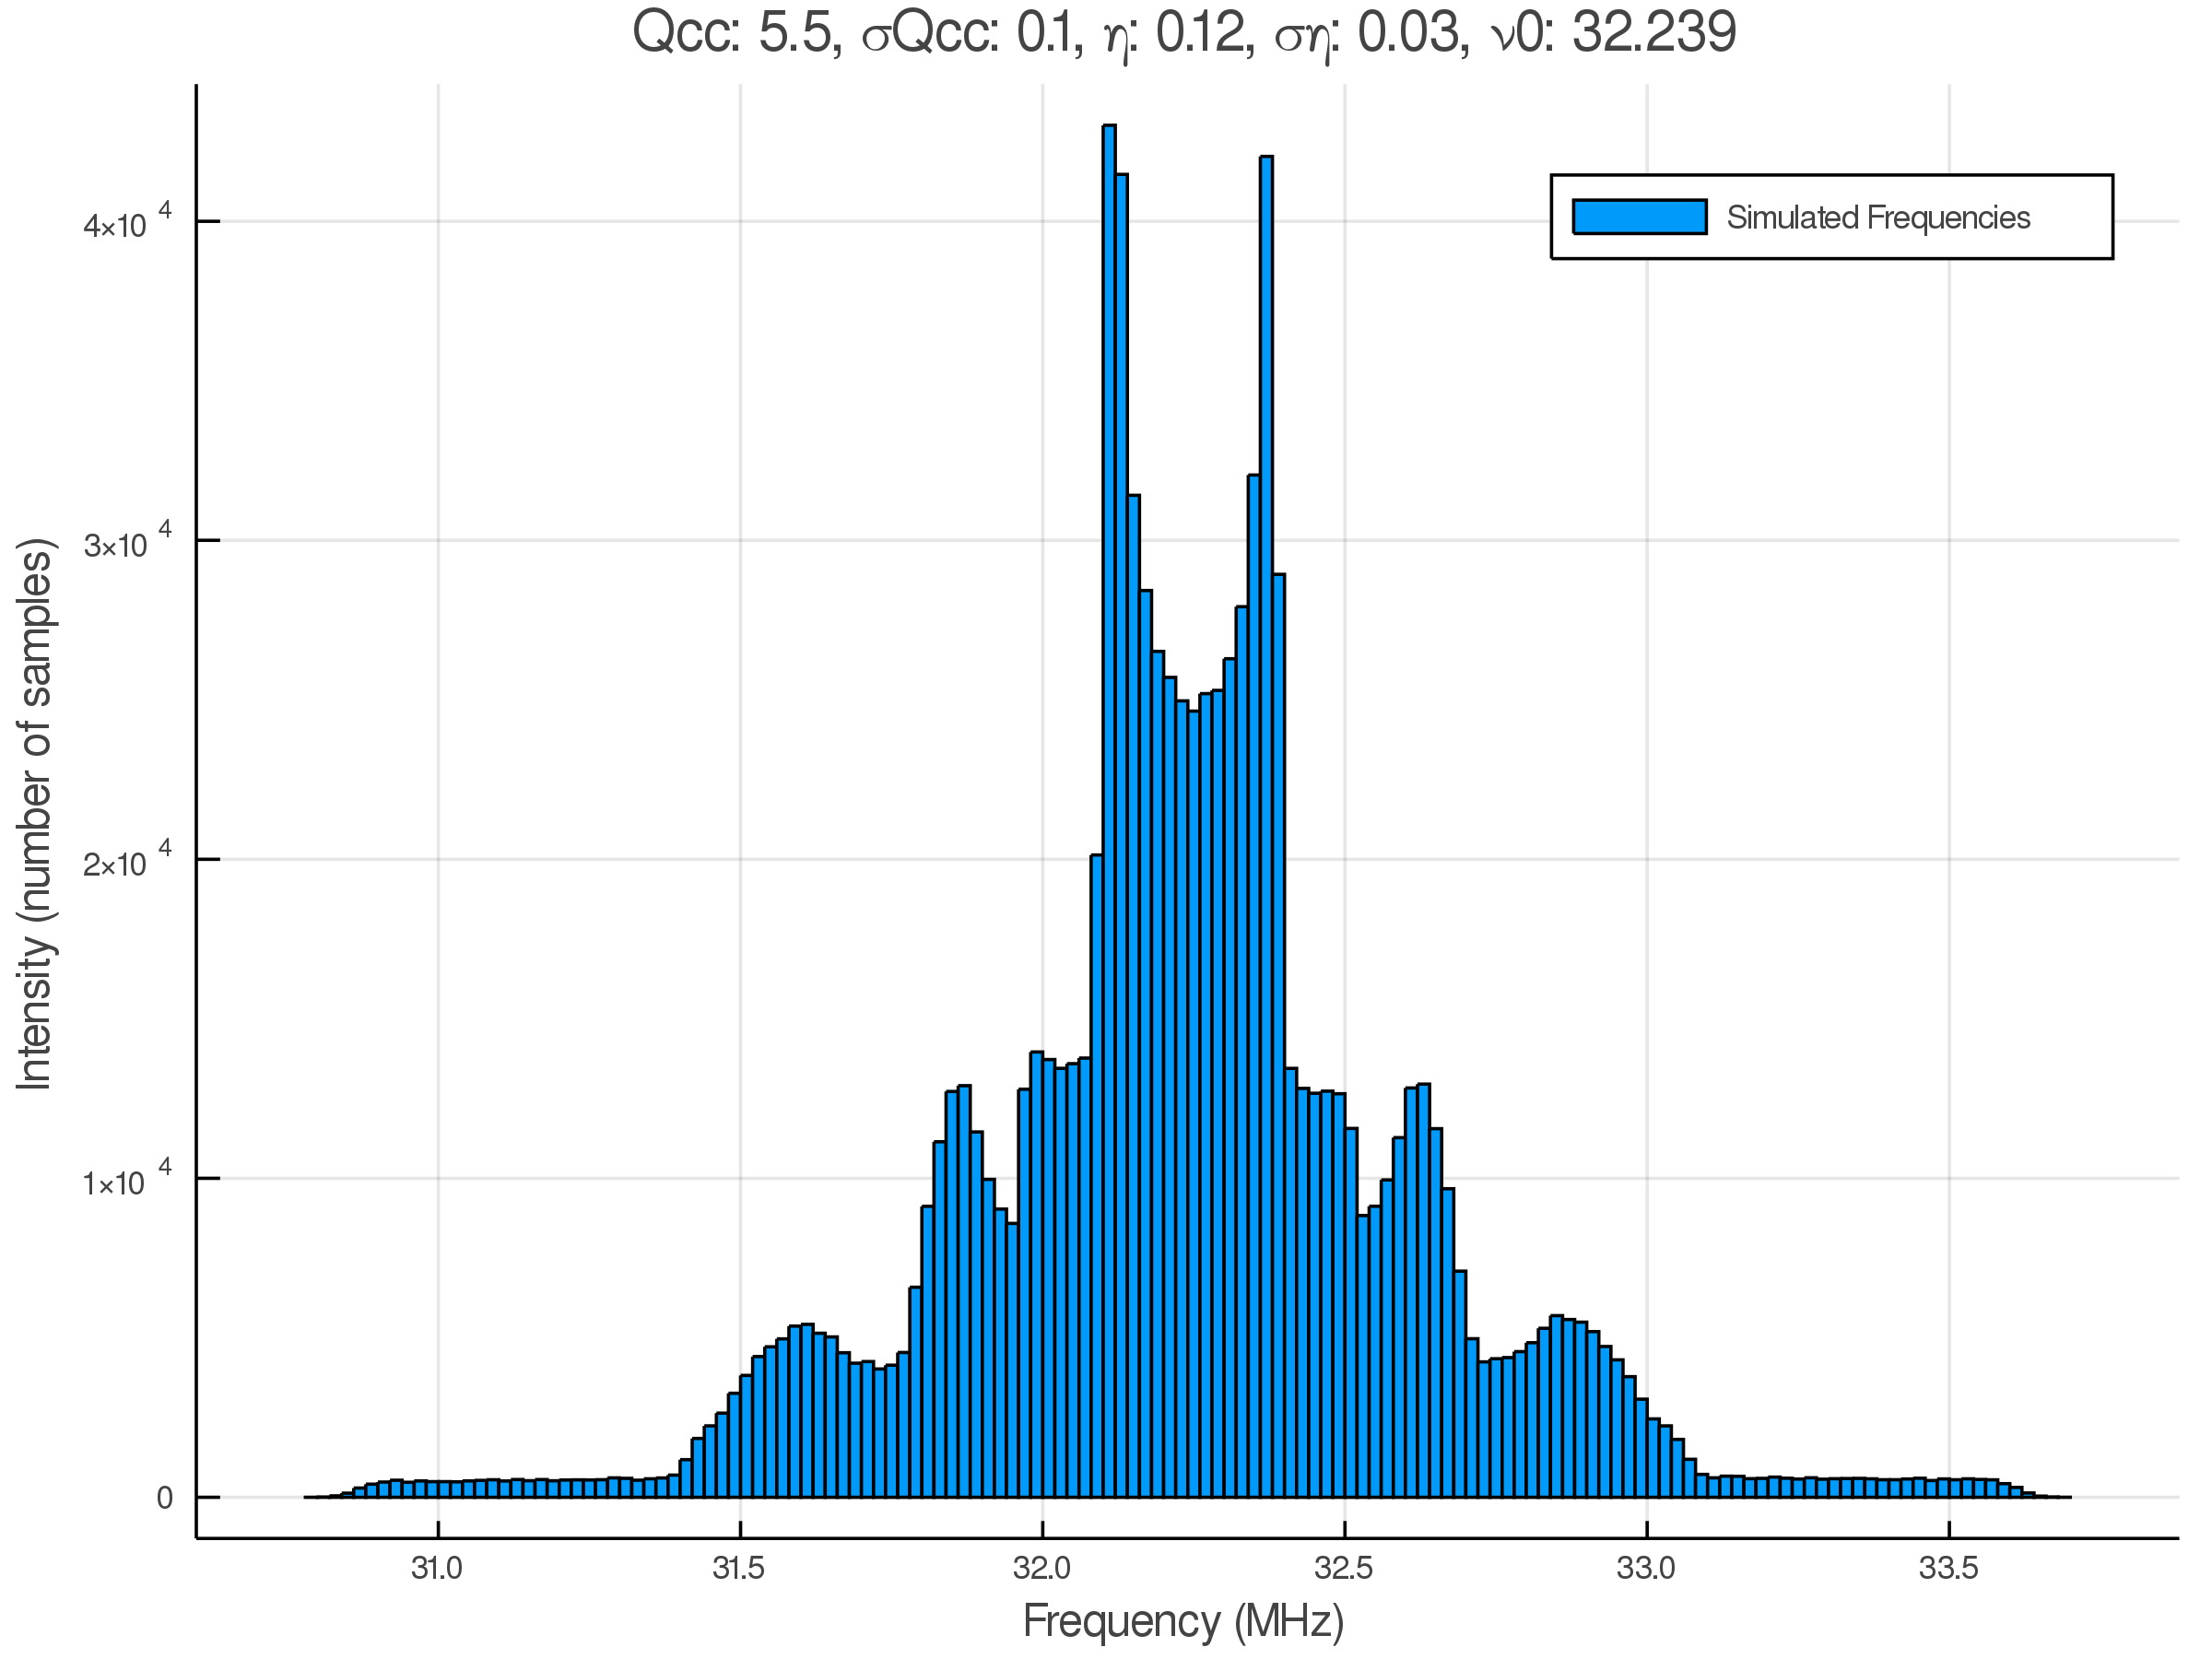

In [3]:
histogram(SpectraFit.estimate_powder_pattern(Quadrupolar([5.5, 0.1, 0.12, 0.03]), 1_000_000, 32.239, 3),
    bins = 250, label = "Simulated Frequencies", xlabel = "Frequency (MHz)", 
    ylabel = "Intensity (number of samples)", size = (800, 600), 
    title = "Qcc: 5.5, σQcc: 0.1, η: 0.12, ση: 0.03, ν0: 32.239", dpi = 300, format = :png)

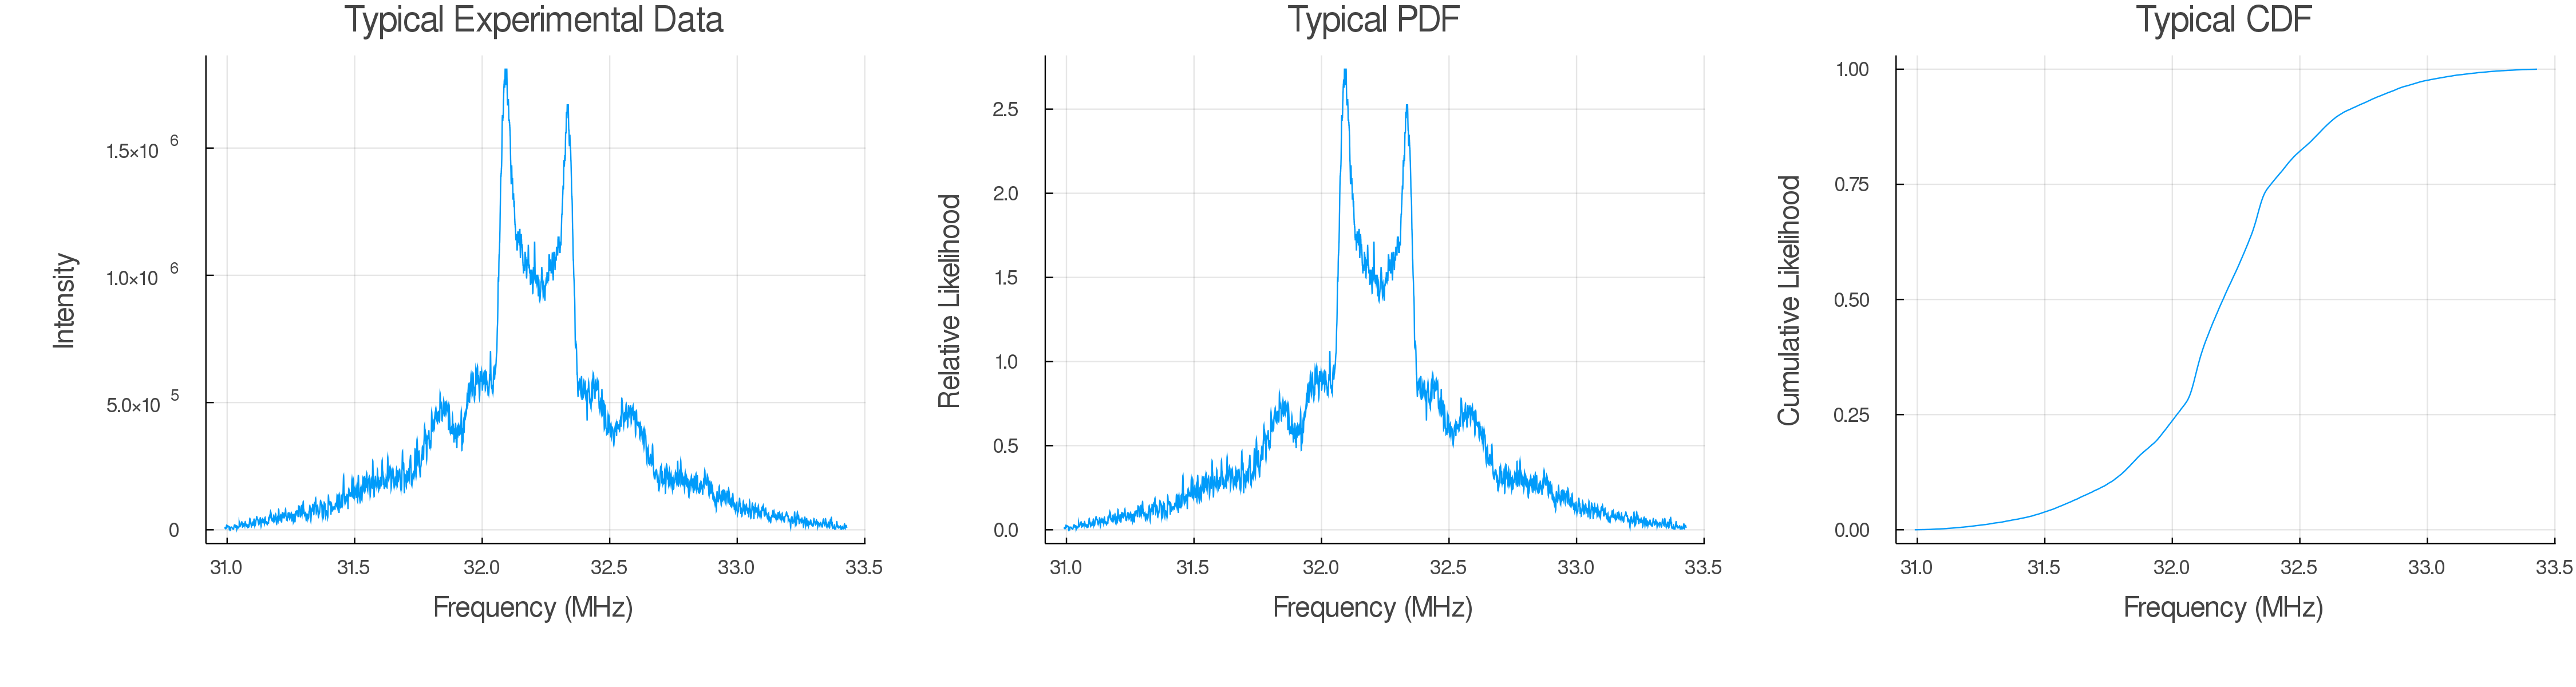

In [4]:
fastcool_exp = get_experimental(get_data("B2O3FastCool.txt"), ν0_guess = 32.239, delim = "  ")
plt1 = plot(fastcool_exp[:, 1], fastcool_exp[:, 2], legend = false, title = "Typical Experimental Data",
    ylabel = "Intensity", xlabel = "Frequency (MHz)")
fastcool_pdf = fastcool_exp[:, 2] .* (0.5 / 
    mean(fastcool_exp[:, 2]))
plt2 = plot(fastcool_exp[:, 1], fastcool_pdf, legend = false, title = "Typical PDF", 
    ylabel = "Relative Likelihood", xlabel = "Frequency (MHz)")
fastcool_cdf = SpectraFit.get_experimental_ecdf(fastcool_exp)
plt3 = plot(fastcool_exp[:, 1], fastcool_cdf, legend = false, title = "Typical CDF",
    ylabel = "Cumulative Likelihood", xlabel = "Frequency (MHz)")
plot(plt1, plt2, plt3, layout = (1, 3), size = (1500, 400), left_margin = 10mm, bottom_margin = 10mm, dpi = 300, format = :png)

In [5]:
savefig("figure2.png")

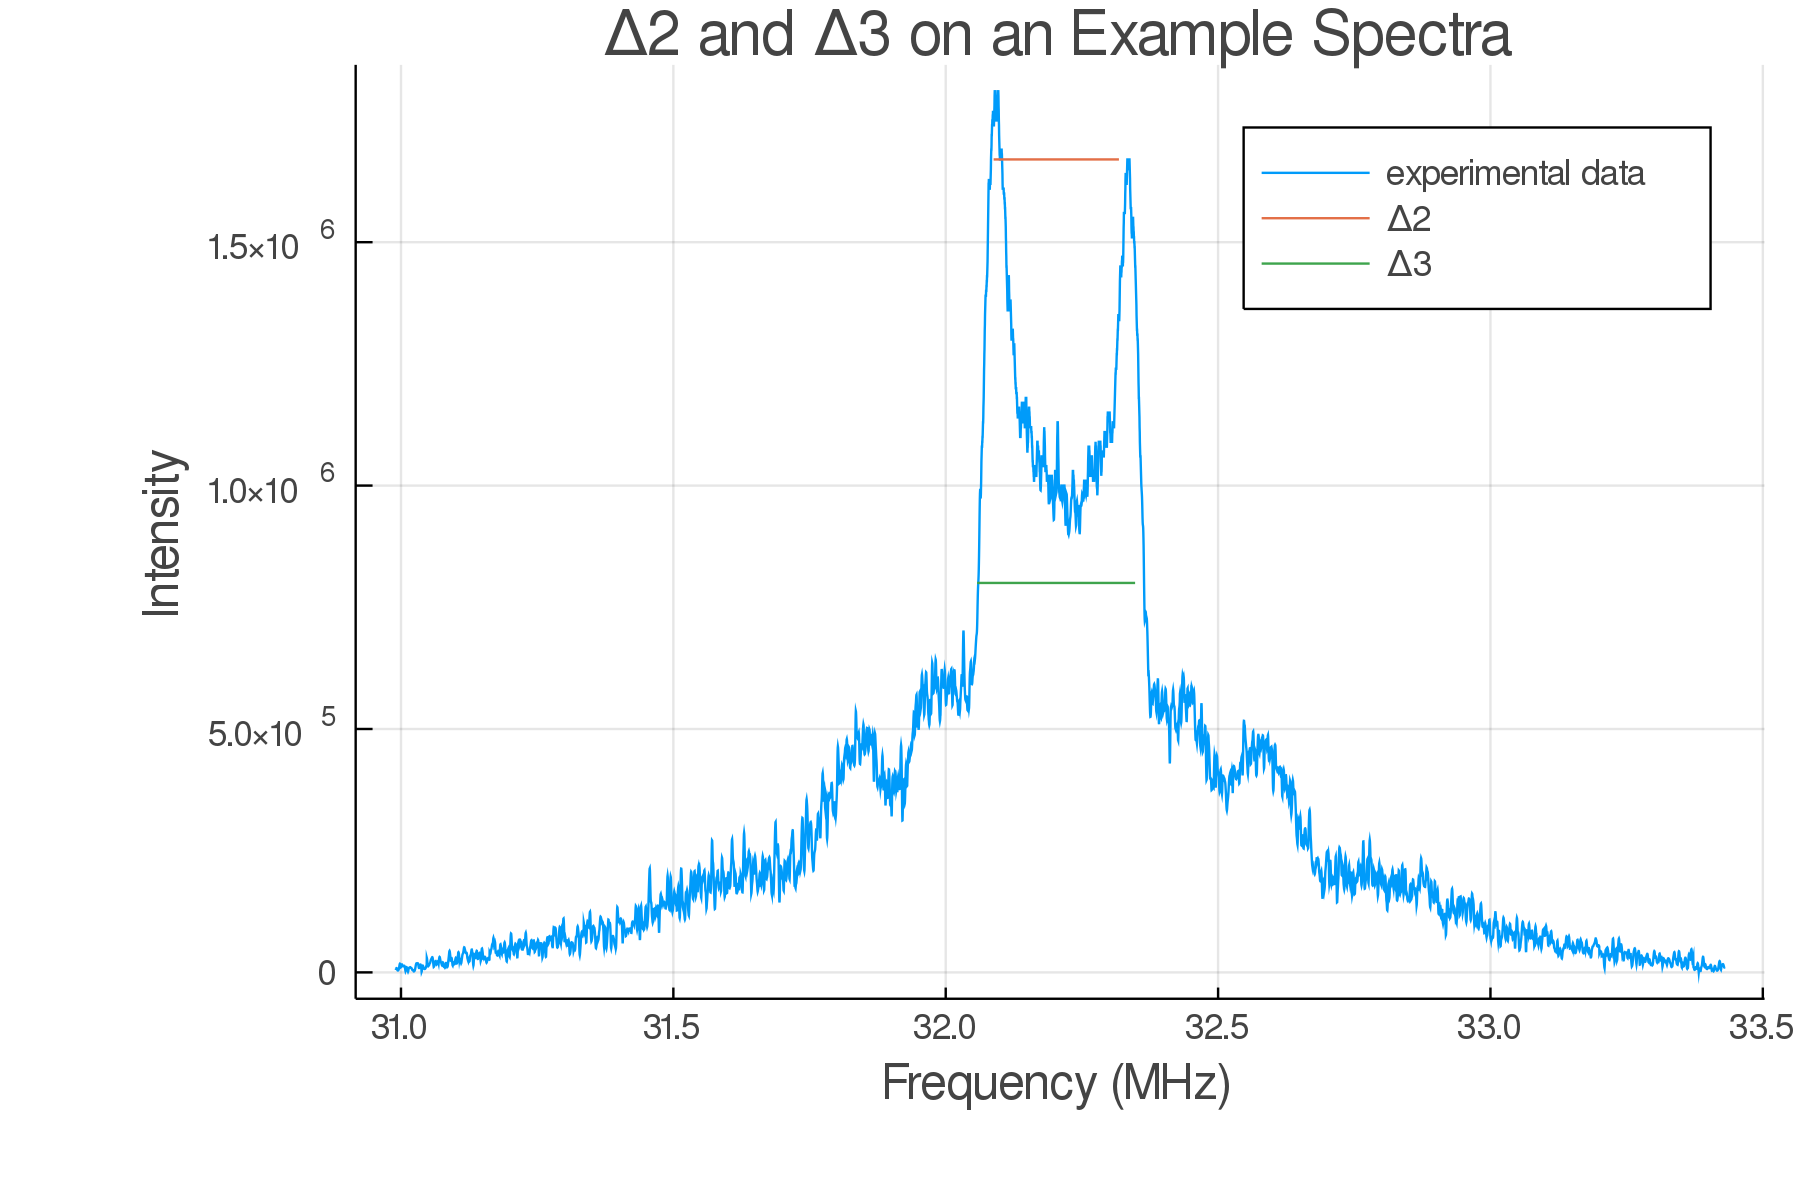

In [6]:
fastcool_exp = get_experimental(get_data("B2O3FastCool.txt"), ν0_guess = 32.239, delim = "  ")
plt1 = plot(fastcool_exp[:, 1], fastcool_exp[:, 2], label = "experimental data", 
    title = "Δ2 and Δ3 on an Example Spectra", ylabel = "Intensity", xlabel = "Frequency (MHz)", 
    left_margin = 10mm, bottom_margin = 10mm, dpi = 300, format = :png)
fastcool_ν0 = SpectraFit.get_ν0(fastcool_exp)
Δ4_xs = fastcool_ν0 - .2303/2:0.01:fastcool_ν0 + .2303/2
Δ4_h(x) = 1.67e6
plot!(plt1, Δ4_xs, Δ4_h.(Δ4_xs), label = "Δ2")
Δ5_xs = fastcool_ν0 - .2909/2:0.01:fastcool_ν0 + .2909/2
Δ5_h(x) = 8e5
plot!(plt1, Δ5_xs, Δ5_h.(Δ5_xs), label = "Δ3")

In [7]:
starting_values_transformed = SpectraFit.get_quadrupolar_starting_values(1)
starting_values = (starting_values_transformed) .^ 2

4-element Array{Float64,1}:
 5.1581994983010215
 0.3693644259463737
 0.7435012881951721
 0.352081608258131

In [8]:
nelder_mead_result = fit_quadrupolar(fastcool_exp, method = "NelderMead", 
    options = Optim.Options(f_calls_limit = 10_000, store_trace = true, iterations = 100_000), 
    starting_values = starting_values_transformed)

 * Status: failure (line search failed)

 * Candidate solution
    Minimizer: [2.34e+00, 5.94e-01, 4.31e-01,  ...]
    Minimum:   2.238496e-01

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [2.27e+00, 6.08e-01, 8.62e-01,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   3785  (vs limit Inf)
    Iterations:    3728
    f(x) calls:    10002


In [9]:
nelder_mead_result.minimizer .^ 2

4-element Array{Float64,1}:
 5.494568475679947
 0.35341744573123457
 0.18547637193203706
 0.9462222708354271

In [10]:
nelder_mead_result.trace

3729-element Array{OptimizationState{Float64,NelderMead{Optim.AffineSimplexer,Optim.AdaptiveParameters}},1}:
      0     8.269646e-01     4.512665e+01
 * time: 0.0

      1     8.269646e-01     1.762284e+01
 * time: 0.7777550220489502

      2     8.269646e-01     6.166579e+00
 * time: 1.5124189853668213

      3     8.269646e-01     1.837984e+00
 * time: 2.2512099742889404

      4     8.269646e-01     3.767118e-01
 * time: 3.002208948135376

      5     8.269646e-01     1.523244e-01
 * time: 3.7381200790405273

      6     7.334451e-01     2.703637e-01
 * time: 4.486902952194214

      7     2.786303e-01     2.687276e-01
 * time: 4.858974933624268

      8     2.786303e-01     2.315333e-01
 * time: 5.249154090881348

      9     2.786303e-01     1.916530e-01
 * time: 6.005743026733398

     10     2.786303e-01     1.518243e-01
 * time: 6.3618080615997314

     11     2.786303e-01     5.807909e-02
 * time: 7.099772930145264

     12     2.786303e-01     3.594642e-02
 * time: 7.8210139

In [11]:
simulated_annealing_result = fit_quadrupolar(fastcool_exp, method = "SimulatedAnnealing", 
    options = Optim.Options(f_calls_limit = 10_000, store_trace = true, iterations = 100_000), 
    starting_values = starting_values)

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 10501

     Obj. value:      0.0734582055

       parameter      search width
         5.58303           0.00000 
         0.63702           0.00000 
         0.06713           0.00000 
         0.13977           0.00000 



 * Status: failure

 * Candidate solution
    Minimizer: [5.58e+00, 6.37e-01, 6.71e-02,  ...]
    Minimum:   7.345821e-02

 * Found with
    Algorithm:     SAMIN
    Initial Point: [5.16e+00, 3.69e-01, 7.44e-01,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   3616  (vs limit Inf)
    Iterations:    10501
    f(x) calls:    10501
    ∇f(x) calls:   0


In [12]:
simulated_annealing_result.trace

10501-element Array{OptimizationState{Float64,SAMIN{Float64}},1}:
      0     9.236582e-01              NaN
 * time: 0.40927600860595703

      1     9.236582e-01              NaN
 * time: 0.7589700222015381

      2     1.097492e+00              NaN
 * time: 1.1027469635009766

      3     1.097492e+00              NaN
 * time: 1.4408719539642334

      4     1.086807e+00              NaN
 * time: 1.777419090270996

      5     4.283135e-01              NaN
 * time: 2.273658037185669

      6     4.269084e-01              NaN
 * time: 2.6724181175231934

      7     3.875009e-01              NaN
 * time: 3.0141470432281494

      8     5.522583e-01              NaN
 * time: 3.3583760261535645

      9     5.522583e-01              NaN
 * time: 3.7044029235839844

     10     5.703219e-01              NaN
 * time: 4.0482399463653564

     11     5.703219e-01              NaN
 * time: 4.394863128662109

     12     2.575509e-01              NaN
 * time: 4.726685047149658

 ⋮
  10489    

In [13]:
particle_swarm_result = fit_quadrupolar(fastcool_exp, method = "ParticleSwarm", 
    options = Optim.Options(f_calls_limit = 10_000, store_trace = true, iterations = 100_000), 
    starting_values = starting_values)

 * Status: failure (line search failed)

 * Candidate solution
    Minimizer: [5.58e+00, 5.40e-01, 4.05e-02,  ...]
    Minimum:   7.179067e-02

 * Found with
    Algorithm:     Particle Swarm
    Initial Point: [5.16e+00, 3.69e-01, 7.44e-01,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 1.0e-08

 * Work counters
    Seconds run:   3293  (vs limit Inf)
    Iterations:    2000
    f(x) calls:    10001
    ∇f(x) calls:   0


In [14]:
ga_best, ga_population, ga_mins, ga_means, ga_maxes = genetic_algorithm(10, fastcool_exp, gens = 1000)
ga_best

Progress: 100%|█████████████████████████████████████████| Time: 0:57:38


([5.580517618318244, 0.569488016311737, 0.0, 0.18909556042734132], 0.07600121387033312)

In [15]:
adaptive_de_rand_1_bin_res, adaptive_de_rand_1_bin_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :adaptive_de_rand_1_bin)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.78 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=27.185267688
1.53 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=27.185267688
2.21 secs, 6 evals, 3 steps, improv/step: 0.667 (last = 0.0000), fitness=0.199179669
2.88 secs, 8 evals, 4 steps, improv/step: 0.500 (last = 0.0000), fitness=0.199179669
3.56 secs, 10 evals, 5 steps, improv/step: 0.400 (last = 0.0000), fitness=0.199179669
4.29 secs, 12 evals, 6 steps, improv/step: 0.500 (last = 1.0000), fitness=0.199179669
4.98 secs, 14 evals, 7 steps, improv/step: 0.429 (last = 0.0000), fitness=0.199179669
5.67 secs, 16 evals, 8 steps, improv/step: 0.500 (last = 1.0000), fitness=0.199179669
6.36 secs, 18 evals, 9 steps, improv/step: 

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9883, 1.601760165391364e9, 3391.088394880295, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 476346,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 27.1852676882215), (4, 27.1852676882215), (6, 0.1991796694892936), (8, 0.1991796694892936), (10, 0.1991796694892936), (12, 0.1991796694892936), (14, 0.1991796694892936), (16, 0.1991796694892936), (18, 0.1991796694892936), (20, 0.1991796694892936)  …  (9992, 0.07462918628960163), (9993, 0.07462918628960163), (9994, 0.07462918628960163), (9995, 0.07462918628960163), (9996, 0.07462918628960163), (9997, 0.07462918628960163), (9998, 0.07462918628960163), (9999, 0.07462918628960163), (10000, 0.07462918628960163), (10001, 0.0

In [16]:
adaptive_de_rand_1_bin_radiuslimited_res, adaptive_de_rand_1_bin_radiuslimited_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :adaptive_de_rand_1_bin_radiuslimited)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.80 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=27.954062248
1.51 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 0.0000), fitness=27.954062248
2.22 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 0.0000), fitness=6.819118360
2.92 secs, 8 evals, 4 steps, improv/step: 0.250 (last = 0.0000), fitness=0.396555006
3.60 secs, 10 evals, 5 steps, improv/step: 0.400 (last = 1.0000), fitness=0.396555006
4.63 secs, 13 evals, 7 steps, improv/step: 0.571 (last = 1.0000), fitness=0.396555006
5.32 secs, 15 evals, 8 steps, improv/step: 0.500 (last = 0.0000), fitness=0.396555006
6.02 secs, 17 evals, 9 steps, improv/step: 0.556 (last = 1.0000), fitness=0.337445912
6.72 secs, 19 evals, 10 steps, improv/step:

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9908, 1.601763558278437e9, 3361.2158420085907, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 958751,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 27.954062247978506), (4, 27.954062247978506), (6, 6.819118359711737), (8, 0.3965550055564776), (10, 0.3965550055564776), (11, 0.3965550055564776), (13, 0.3965550055564776), (15, 0.3965550055564776), (17, 0.33744591228120685), (19, 0.33744591228120685)  …  (9992, 0.0745299023963095), (9993, 0.0745299023963095), (9994, 0.0745299023963095), (9995, 0.0745299023963095), (9996, 0.0745299023963095), (9997, 0.0745299023963095), (9998, 0.0745299023963095), (9999, 0.0745299023963095), (10000, 0.0745299023963095), (10001, 0.0745

In [17]:
separable_nes_res, separable_nes_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :separable_nes)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.67 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=1.411732455
1.37 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=1.013267386
2.07 secs, 6 evals, 3 steps, improv/step: 1.000 (last = 1.0000), fitness=0.806043759
2.76 secs, 8 evals, 4 steps, improv/step: 1.000 (last = 1.0000), fitness=0.806043759
3.42 secs, 10 evals, 5 steps, improv/step: 1.000 (last = 1.0000), fitness=0.806043759
4.09 secs, 12 evals, 6 steps, improv/step: 1.000 (last = 1.0000), fitness=0.806043759
4.75 secs, 14 evals, 7 steps, improv/step: 0.857 (last = 0.0000), fitness=0.806043759
5.43 secs, 16 evals, 8 steps, improv/step: 0.875 (last = 1.0000), fitness=0.806043759
6.15 secs, 18 evals, 9 steps, improv/step: 0.

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9906, 1.601766919858313e9, 3376.285810947418, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 580131,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 1.4117324548613763), (4, 1.013267385798782), (6, 0.8060437592473509), (8, 0.8060437592473509), (10, 0.8060437592473509), (12, 0.8060437592473509), (14, 0.8060437592473509), (16, 0.8060437592473509), (18, 0.8060437592473509), (20, 0.8060437592473509)  …  (9992, 0.07487354640098398), (9993, 0.07487354640098398), (9994, 0.07487354640098398), (9995, 0.07487354640098398), (9996, 0.07487354640098398), (9997, 0.07487354640098398), (9998, 0.07487354640098398), (9999, 0.07487354640098398), (10000, 0.07487354640098398), (10001, 

In [18]:
xnes_res, xnes_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :xnes)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.67 secs, 2 evals, 1 steps, fitness=9.333697754
1.38 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 1.0000), fitness=9.333697754
2.06 secs, 6 evals, 3 steps, improv/step: 0.667 (last = 1.0000), fitness=1.893150069
2.72 secs, 8 evals, 4 steps, improv/step: 0.750 (last = 1.0000), fitness=1.893150069
3.78 secs, 11 evals, 6 steps, improv/step: 0.667 (last = 0.5000), fitness=1.893150069
4.45 secs, 13 evals, 7 steps, improv/step: 0.714 (last = 1.0000), fitness=1.893150069
5.48 secs, 16 evals, 9 steps, improv/step: 0.667 (last = 0.5000), fitness=0.614732299
6.17 secs, 18 evals, 10 steps, improv/step: 0.600 (last = 0.0000), fitness=0.614732299
6.88 secs, 20 evals, 11 steps, improv/step: 0.545 (last = 0.0000), fitness=0.614

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9903, 1.601770296504181e9, 3381.7421550750732, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 762455,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 9.333697754100928), (4, 9.333697754100928), (6, 1.893150068892181), (8, 1.893150068892181), (9, 1.893150068892181), (11, 1.893150068892181), (13, 1.893150068892181), (14, 0.7204595713612116), (16, 0.6147322985040622), (18, 0.6147322985040622)  …  (9992, 0.0763379123174204), (9993, 0.0763379123174204), (9994, 0.0763379123174204), (9995, 0.0763379123174204), (9996, 0.0763379123174204), (9997, 0.0763379123174204), (9998, 0.0763379123174204), (9999, 0.0763379123174204), (10000, 0.0763379123174204), (10001, 0.0763379123174

In [19]:
de_rand_1_bin_res, de_rand_1_bin_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :de_rand_1_bin)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.68 secs, 2 evals, 1 steps, fitness=16.707821483
1.38 secs, 4 evals, 2 steps, fitness=16.707821483
2.06 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 1.0000), fitness=16.707821483
2.76 secs, 8 evals, 4 steps, improv/step: 0.250 (last = 0.0000), fitness=3.364064770
3.43 secs, 10 evals, 5 steps, improv/step: 0.200 (last = 0.0000), fitness=0.125665781
4.11 secs, 12 evals, 6 steps, improv/step: 0.167 (last = 0.0000), fitness=0.125665781
4.80 secs, 14 evals, 7 steps, improv/step: 0.286 (last = 1.0000), fitness=0.125665781
5.50 secs, 16 evals, 8 steps, improv/step: 0.375 (last = 1.0000), fitness=0.125665781
6.20 secs, 18 evals, 9 steps, improv/step: 0.444 (last = 1.0000), fitness=0.125665781
6.87 secs, 20 evals, 10 step

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9886, 1.601773678597442e9, 3392.8426570892334, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 729027,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 16.70782148299947), (4, 16.70782148299947), (6, 16.70782148299947), (8, 3.364064770043957), (10, 0.12566578112899857), (12, 0.12566578112899857), (14, 0.12566578112899857), (16, 0.12566578112899857), (18, 0.12566578112899857), (20, 0.12566578112899857)  …  (9992, 0.07488947134724522), (9993, 0.07488947134724522), (9994, 0.07488947134724522), (9995, 0.07488947134724522), (9996, 0.07488947134724522), (9997, 0.07488947134724522), (9998, 0.07488947134724522), (9999, 0.07488947134724522), (10000, 0.07488947134724522), (100

In [20]:
de_rand_2_bin_res, de_rand_2_bin_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :de_rand_2_bin)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.70 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=1.892964292
1.39 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 0.0000), fitness=1.892964292
2.07 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 0.0000), fitness=1.214105246
2.79 secs, 8 evals, 4 steps, improv/step: 0.250 (last = 0.0000), fitness=1.214105246
3.48 secs, 10 evals, 5 steps, improv/step: 0.400 (last = 1.0000), fitness=0.683920042
4.20 secs, 12 evals, 6 steps, improv/step: 0.500 (last = 1.0000), fitness=0.683920042
4.87 secs, 14 evals, 7 steps, improv/step: 0.571 (last = 1.0000), fitness=0.683920042
5.58 secs, 16 evals, 8 steps, improv/step: 0.500 (last = 0.0000), fitness=0.683920042
6.24 secs, 18 evals, 9 steps, improv/step: 0.

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9908, 1.60177707178808e9, 3351.730794906616, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 46232,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 1.8929642919950753), (4, 1.8929642919950753), (6, 1.214105245629863), (8, 1.214105245629863), (10, 0.6839200423689731), (12, 0.6839200423689731), (14, 0.6839200423689731), (16, 0.6839200423689731), (18, 0.6839200423689731), (20, 0.3388229056475752)  …  (9992, 0.07448377860388933), (9993, 0.07448377860388933), (9994, 0.07448377860388933), (9995, 0.07448377860388933), (9996, 0.07448377860388933), (9997, 0.07448377860388933), (9998, 0.07448377860388933), (9999, 0.07448377860388933), (10000, 0.07448377860388933), (10001, 0.0

In [21]:
de_rand_1_bin_radiuslimited_res, de_rand_1_bin_radiuslimited_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :de_rand_1_bin_radiuslimited)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.70 secs, 2 evals, 1 steps, fitness=36.596360557
1.40 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 1.0000), fitness=1.446557221
2.07 secs, 6 evals, 3 steps, improv/step: 0.667 (last = 1.0000), fitness=1.446557221
2.77 secs, 8 evals, 4 steps, improv/step: 0.750 (last = 1.0000), fitness=1.446557221
3.47 secs, 10 evals, 5 steps, improv/step: 0.800 (last = 1.0000), fitness=1.446557221
4.14 secs, 12 evals, 6 steps, improv/step: 0.833 (last = 1.0000), fitness=1.446557221
4.81 secs, 14 evals, 7 steps, improv/step: 0.714 (last = 0.0000), fitness=1.446557221
5.54 secs, 16 evals, 8 steps, improv/step: 0.750 (last = 1.0000), fitness=1.446557221
6.27 secs, 18 evals, 9 steps, improv/step: 0.667 (last = 0.0000), fitness=1.4465

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9882, 1.601780423860411e9, 3399.7643530368805, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 425486,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 36.59636055659412), (4, 1.4465572205974522), (6, 1.4465572205974522), (8, 1.4465572205974522), (10, 1.4465572205974522), (12, 1.4465572205974522), (14, 1.4465572205974522), (16, 1.4465572205974522), (18, 1.4465572205974522), (20, 1.4465572205974522)  …  (9992, 0.07535282008092932), (9993, 0.07535282008092932), (9994, 0.07535282008092932), (9995, 0.07535282008092932), (9996, 0.07535282008092932), (9997, 0.07535282008092932), (9998, 0.07535282008092932), (9999, 0.07535282008092932), (10000, 0.07535282008092932), (10001,

In [22]:
de_rand_2_bin_radiuslimited_res, de_rand_2_bin_radiuslimited_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :de_rand_2_bin_radiuslimited)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.72 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=209.209982317
1.43 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=1.981618998
2.15 secs, 6 evals, 3 steps, improv/step: 1.000 (last = 1.0000), fitness=0.260307976
2.84 secs, 8 evals, 4 steps, improv/step: 1.000 (last = 1.0000), fitness=0.260307976
3.55 secs, 10 evals, 5 steps, improv/step: 0.800 (last = 0.0000), fitness=0.260307976
4.63 secs, 13 evals, 7 steps, improv/step: 0.714 (last = 0.5000), fitness=0.150790778
5.32 secs, 15 evals, 8 steps, improv/step: 0.625 (last = 0.0000), fitness=0.150790778
5.99 secs, 17 evals, 9 steps, improv/step: 0.556 (last = 0.0000), fitness=0.150790778
6.69 secs, 19 evals, 10 steps, improv/step:

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9886, 1.601783823980466e9, 3387.6972110271454, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 673460,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 209.20998231652948), (4, 1.9816189978215557), (6, 0.2603079758732983), (8, 0.2603079758732983), (10, 0.2603079758732983), (11, 0.15079077821046005), (13, 0.15079077821046005), (15, 0.15079077821046005), (17, 0.15079077821046005), (19, 0.15079077821046005)  …  (9992, 0.07413683648220439), (9993, 0.07413683648220439), (9994, 0.07413683648220439), (9995, 0.07413683648220439), (9996, 0.07413683648220439), (9997, 0.07413683648220439), (9998, 0.07413683648220439), (9999, 0.07413683648220439), (10000, 0.07413683648220439), (

In [23]:
random_search_res, random_search_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :random_search)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.69 secs, 2 evals, 1 steps, fitness=0.471782918
1.42 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 1.0000), fitness=0.471782918
2.08 secs, 6 evals, 3 steps, improv/step: 0.667 (last = 1.0000), fitness=0.471782918
2.76 secs, 8 evals, 4 steps, improv/step: 0.750 (last = 1.0000), fitness=0.471782918
3.44 secs, 10 evals, 5 steps, improv/step: 0.600 (last = 0.0000), fitness=0.471782918
4.13 secs, 12 evals, 6 steps, improv/step: 0.667 (last = 1.0000), fitness=0.471782918
4.80 secs, 14 evals, 7 steps, improv/step: 0.571 (last = 0.0000), fitness=0.471782918
5.49 secs, 16 evals, 8 steps, improv/step: 0.625 (last = 1.0000), fitness=0.471782918
6.53 secs, 19 evals, 10 steps, improv/step: 0.600 (last = 0.5000), fitness=0.4717

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9905, 1.601787212020277e9, 3388.841285943985, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 132953,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 0.47178291809357), (4, 0.47178291809357), (6, 0.47178291809357), (8, 0.47178291809357), (10, 0.47178291809357), (12, 0.47178291809357), (14, 0.47178291809357), (16, 0.47178291809357), (17, 0.47178291809357), (19, 0.47178291809357)  …  (9992, 0.0754353061782367), (9993, 0.0754353061782367), (9994, 0.0754353061782367), (9995, 0.0754353061782367), (9996, 0.0754353061782367), (9997, 0.0754353061782367), (9998, 0.0754353061782367), (9999, 0.0754353061782367), (10000, 0.0754353061782367), (10001, 0.0754353061782367)]),:MaxSt

In [24]:
generating_set_search_res, generating_set_search_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :generating_set_search)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.69 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=13.271434097
1.41 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=8.156039142
2.44 secs, 7 evals, 4 steps, improv/step: 0.750 (last = 0.5000), fitness=4.478991808
3.14 secs, 9 evals, 5 steps, improv/step: 0.800 (last = 1.0000), fitness=4.478991808
3.81 secs, 11 evals, 6 steps, improv/step: 0.833 (last = 1.0000), fitness=3.906605096
4.52 secs, 13 evals, 7 steps, improv/step: 0.714 (last = 0.0000), fitness=3.906605096
5.20 secs, 15 evals, 8 steps, improv/step: 0.625 (last = 0.0000), fitness=0.294339937
5.88 secs, 17 evals, 9 steps, improv/step: 0.556 (last = 0.0000), fitness=0.294339937
6.59 secs, 19 evals, 10 steps, improv/step: 

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9898, 1.601790601225177e9, 3359.8297860622406, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 951404,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 13.271434096611875), (4, 8.156039141890691), (5, 4.478991807649411), (7, 4.478991807649411), (9, 4.478991807649411), (11, 3.906605095501234), (13, 3.906605095501234), (15, 0.294339936595555), (17, 0.294339936595555), (19, 0.294339936595555)  …  (9992, 0.0730572190544912), (9993, 0.0730572190544912), (9994, 0.0730572190544912), (9995, 0.0730572190544912), (9996, 0.0730572190544912), (9997, 0.0730572190544912), (9998, 0.0730572190544912), (9999, 0.0730572190544912), (10000, 0.0730572190544912), (10001, 0.073057219054491

In [25]:
probabilistic_descent_res, probabilistic_descent_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :probabilistic_descent)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.71 secs, 2 evals, 1 steps, fitness=98.028939216
1.38 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 1.0000), fitness=11.830063702
2.44 secs, 7 evals, 4 steps, improv/step: 0.250 (last = 0.0000), fitness=11.830063702
3.15 secs, 9 evals, 5 steps, improv/step: 0.400 (last = 1.0000), fitness=5.570851392
3.81 secs, 11 evals, 6 steps, improv/step: 0.333 (last = 0.0000), fitness=1.619413975
4.48 secs, 13 evals, 7 steps, improv/step: 0.429 (last = 1.0000), fitness=1.619413975
5.15 secs, 15 evals, 8 steps, improv/step: 0.500 (last = 1.0000), fitness=0.569980823
5.84 secs, 17 evals, 9 steps, improv/step: 0.556 (last = 1.0000), fitness=0.569980823
6.52 secs, 19 evals, 10 steps, improv/step: 0.600 (last = 1.0000), fitness=0.5

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9903, 1.601793961413347e9, 3415.6573100090027, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 374664,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 98.02893921569441), (4, 11.830063702002946), (5, 11.830063702002946), (7, 11.830063702002946), (9, 5.570851392089707), (11, 1.6194139751741248), (13, 1.6194139751741248), (15, 0.5699808227374046), (17, 0.5699808227374046), (19, 0.5699808227374046)  …  (9992, 0.0755671659915817), (9993, 0.0755671659915817), (9994, 0.0755671659915817), (9995, 0.0755671659915817), (9996, 0.0755671659915817), (9997, 0.0755671659915817), (9998, 0.0755671659915817), (9999, 0.0755671659915817), (10000, 0.0755671659915817), (10001, 0.07556716

In [26]:
resampling_memetic_search_res, resampling_memetic_search_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :resampling_memetic_search)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.70 secs, 2 evals, 1 steps, fitness=33.328921118
1.41 secs, 4 evals, 2 steps, fitness=0.945660192
2.10 secs, 6 evals, 3 steps, fitness=0.945660192
2.80 secs, 8 evals, 4 steps, improv/step: 0.250 (last = 1.0000), fitness=0.945660192
3.50 secs, 10 evals, 5 steps, improv/step: 0.400 (last = 1.0000), fitness=0.595802993
4.20 secs, 12 evals, 6 steps, improv/step: 0.500 (last = 1.0000), fitness=0.595802993
4.90 secs, 14 evals, 7 steps, improv/step: 0.429 (last = 0.0000), fitness=0.595802993
5.57 secs, 16 evals, 8 steps, improv/step: 0.375 (last = 0.0000), fitness=0.595802993
6.27 secs, 18 evals, 9 steps, improv/step: 0.333 (last = 0.0000), fitness=0.595802993
6.96 secs, 20 evals, 10 steps, improv/step: 0.300 (last = 0.0000),

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9893, 1.601797377419652e9, 3345.017513990402, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 446139,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 33.32892111770131), (4, 0.945660191980272), (6, 0.945660191980272), (8, 0.945660191980272), (10, 0.5958029927778846), (12, 0.5958029927778846), (14, 0.5958029927778846), (16, 0.5958029927778846), (18, 0.5958029927778846), (20, 0.5958029927778846)  …  (9992, 0.07414678630378978), (9993, 0.07414678630378978), (9994, 0.07414678630378978), (9995, 0.07414678630378978), (9996, 0.07414678630378978), (9997, 0.07414678630378978), (9998, 0.07414678630378978), (9999, 0.07414678630378978), (10000, 0.07414678630378978), (10001, 0.0

In [27]:
resampling_inheritance_memetic_search_res, resampling_inheritance_memetic_search_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :resampling_inheritance_memetic_search)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.69 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=1.644934926
1.36 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=1.644934926
2.03 secs, 6 evals, 3 steps, improv/step: 1.000 (last = 1.0000), fitness=1.644934926
2.70 secs, 8 evals, 4 steps, improv/step: 0.750 (last = 0.0000), fitness=1.154280856
3.42 secs, 10 evals, 5 steps, improv/step: 0.600 (last = 0.0000), fitness=1.154280856
4.09 secs, 12 evals, 6 steps, improv/step: 0.500 (last = 0.0000), fitness=1.154280856
4.79 secs, 14 evals, 7 steps, improv/step: 0.429 (last = 0.0000), fitness=1.154280856
5.48 secs, 16 evals, 8 steps, improv/step: 0.375 (last = 0.0000), fitness=1.154280856
6.14 secs, 18 evals, 9 steps, improv/step: 0.

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9868, 1.601800722810763e9, 3377.2023561000824, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 596018,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 1.6449349257018664), (4, 1.6449349257018664), (6, 1.6449349257018664), (8, 1.1542808562094486), (10, 1.1542808562094486), (12, 1.1542808562094486), (14, 1.1542808562094486), (16, 1.1542808562094486), (18, 1.1542808562094486), (20, 1.1542808562094486)  …  (9992, 0.07393075834070215), (9993, 0.07393075834070215), (9994, 0.07393075834070215), (9995, 0.07393075834070215), (9996, 0.07393075834070215), (9997, 0.07393075834070215), (9998, 0.07393075834070215), (9999, 0.07393075834070215), (10000, 0.07393075834070215), (10001

In [28]:
simultaneous_perturbation_stochastic_approximation_res, simultaneous_perturbation_stochastic_approximation_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :simultaneous_perturbation_stochastic_approximation)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.69 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=0.383429068
1.40 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=0.383429068
2.11 secs, 6 evals, 3 steps, improv/step: 0.667 (last = 0.0000), fitness=0.383429068
2.82 secs, 8 evals, 4 steps, improv/step: 0.500 (last = 0.0000), fitness=0.383429068
3.49 secs, 10 evals, 5 steps, improv/step: 0.600 (last = 1.0000), fitness=0.383429068
4.17 secs, 12 evals, 6 steps, improv/step: 0.667 (last = 1.0000), fitness=0.383429068
4.87 secs, 14 evals, 7 steps, improv/step: 0.571 (last = 0.0000), fitness=0.383429068
5.55 secs, 16 evals, 8 steps, improv/step: 0.625 (last = 1.0000), fitness=0.383429068
6.22 secs, 18 evals, 9 steps, improv/step: 0.

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9916, 1.6018041003599e9, 3354.0486540794373, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 280887,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 0.38342906833525103), (4, 0.38342906833525103), (6, 0.38342906833525103), (8, 0.38342906833525103), (10, 0.38342906833525103), (12, 0.38342906833525103), (14, 0.38342906833525103), (16, 0.38342906833525103), (18, 0.38342906833525103), (20, 0.38342906833525103)  …  (9992, 0.07499254351613038), (9993, 0.07499254351613038), (9994, 0.07499254351613038), (9995, 0.07499254351613038), (9996, 0.07499254351613038), (9997, 0.07499254351613038), (9998, 0.07499254351613038), (9999, 0.07499254351613038), (10000, 0.07499254351613038)

In [35]:
dxnes_res, dxnes_trace = 
    fit_quadrupolar_bb(fastcool_exp, max_func_evals = 10_000, method = :dxnes)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.70 secs, 2 evals, 1 steps, fitness=16.451671427
1.45 secs, 4 evals, 2 steps, improv/step: 0.500 (last = 1.0000), fitness=16.451671427
2.22 secs, 6 evals, 3 steps, improv/step: 0.333 (last = 0.0000), fitness=9.366382853
2.92 secs, 8 evals, 4 steps, improv/step: 0.250 (last = 0.0000), fitness=9.366382853
3.63 secs, 10 evals, 5 steps, improv/step: 0.200 (last = 0.0000), fitness=2.172909179
4.37 secs, 12 evals, 6 steps, improv/step: 0.333 (last = 1.0000), fitness=1.809203586
5.05 secs, 14 evals, 7 steps, improv/step: 0.286 (last = 0.0000), fitness=0.638575827
5.75 secs, 16 evals, 8 steps, improv/step: 0.250 (last = 0.0000), fitness=0.638575827
6.46 secs, 18 evals, 9 steps, improv/step: 0.222 (last = 0.0000), fitness=0.638

(BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of function evaluations (10000) reached", 9881, 1.601828790846169e9, 3428.3455109596252, BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(:CallbackInterval => 0.0,:RngSeed => 460673,:SearchRange => [(0.0, 9.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)],:MaxFuncEvals => 10000,:CallbackFunction => SpectraFit.var"#42#44"{Array{Tuple{Int64,Float64},1}}([(2, 16.451671426906696), (4, 16.451671426906696), (6, 9.366382853347407), (8, 9.366382853347407), (10, 2.1729091794566573), (12, 1.8092035856701103), (14, 0.6385758265117102), (16, 0.6385758265117102), (18, 0.6385758265117102), (20, 0.6385758265117102)  …  (9992, 0.07376532882474368), (9993, 0.07376532882474368), (9994, 0.07376532882474368), (9995, 0.07376532882474368), (9996, 0.07376532882474368), (9997, 0.07376532882474368), (9998, 0.07376532882474368), (9999, 0.07376532882474368), (10000, 0.07376532882474368), (10001, 

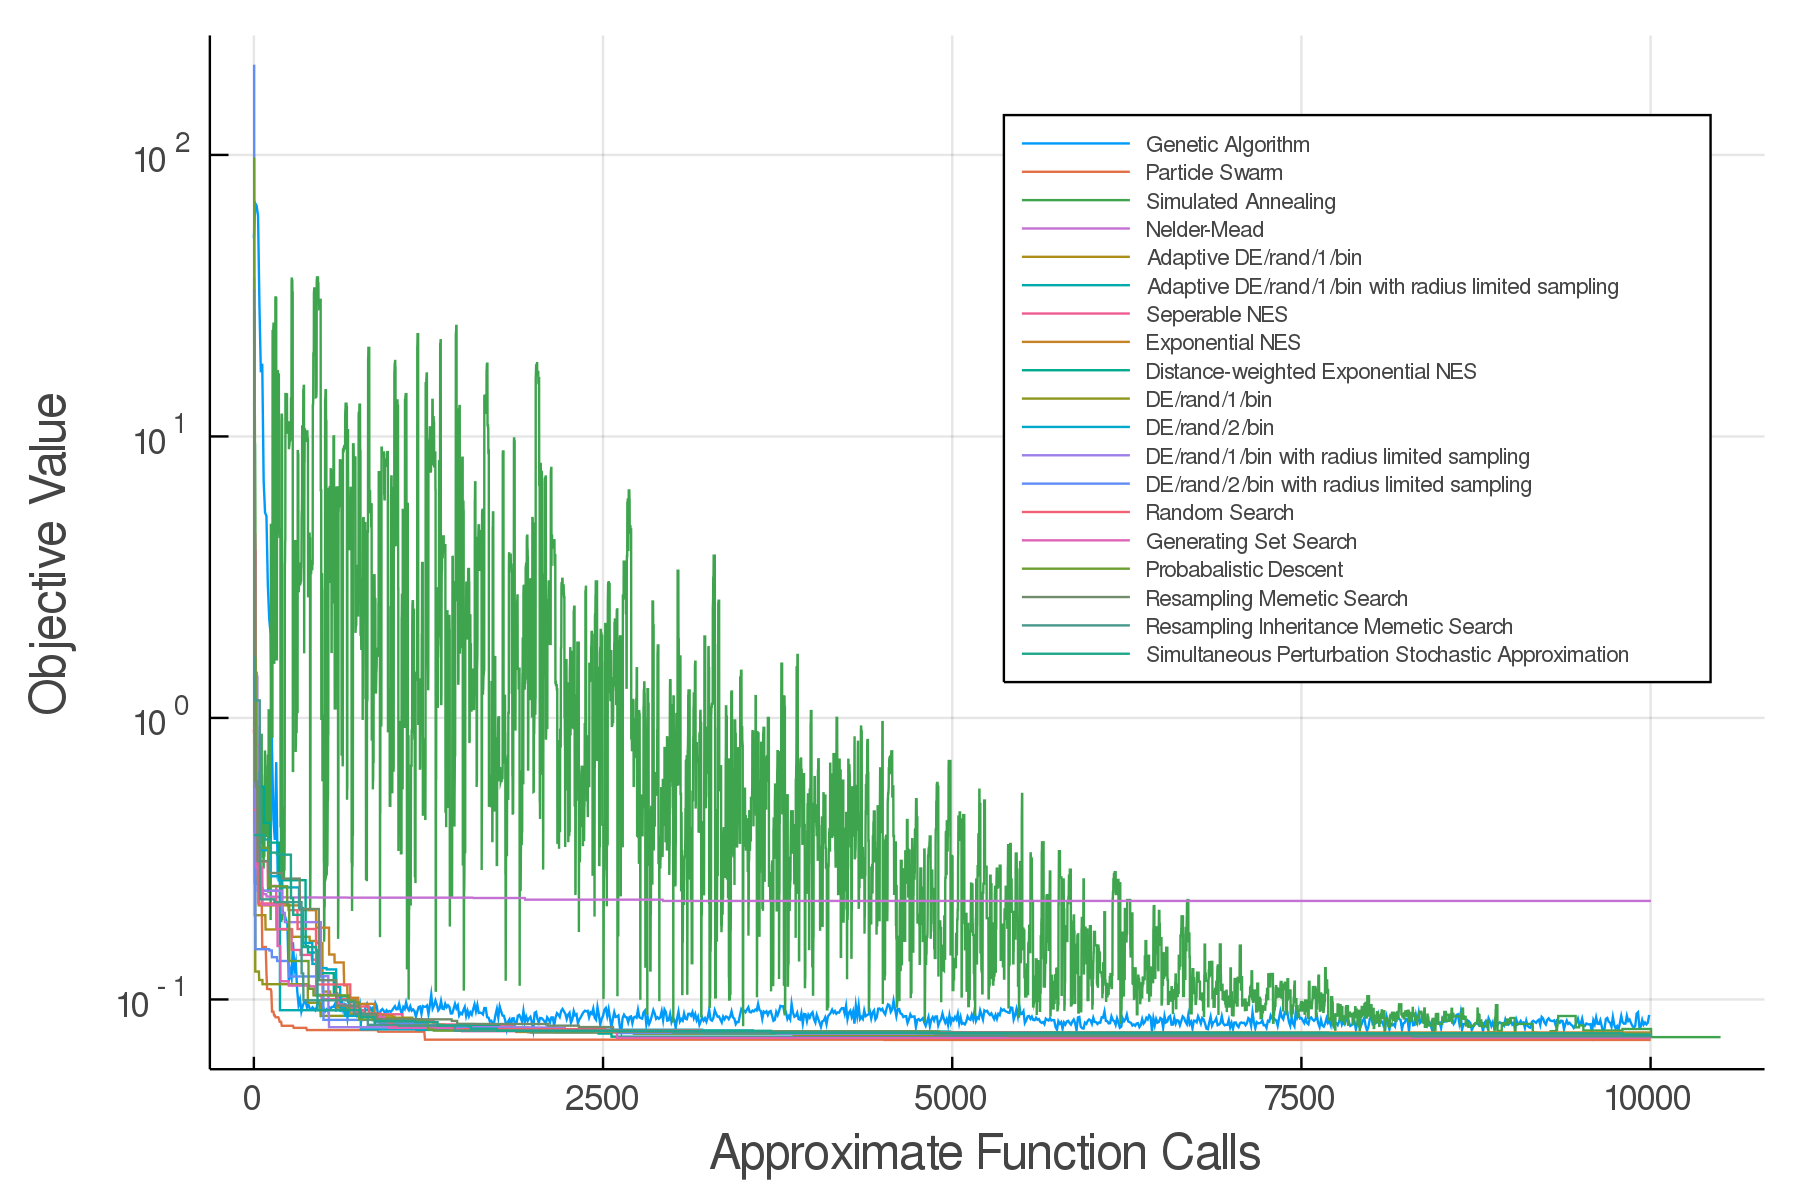

In [38]:
N = 10_000
plot(0:(N ÷ length(ga_mins)):(N - 1), ga_mins, label = "Genetic Algorithm")
plot!(collect(0:particle_swarm_result.iterations) .* (particle_swarm_result.f_calls / 
    particle_swarm_result.iterations), map(x -> x.value, particle_swarm_result.trace), 
    label = "Particle Swarm")
plot!(collect(1:simulated_annealing_result.iterations) .* (simulated_annealing_result.f_calls / 
    simulated_annealing_result.iterations), map(x -> x.value, simulated_annealing_result.trace), 
    label = "Simulated Annealing")
plot!(collect(0:nelder_mead_result.iterations) .* (nelder_mead_result.f_calls / 
    nelder_mead_result.iterations), map(x -> x.value, nelder_mead_result.trace), label = "Nelder-Mead")
plot!(first.(adaptive_de_rand_1_bin_trace), last.(adaptive_de_rand_1_bin_trace), label = "Adaptive DE/rand/1/bin")
plot!(first.(adaptive_de_rand_1_bin_radiuslimited_trace), last.(adaptive_de_rand_1_bin_radiuslimited_trace), label = "Adaptive DE/rand/1/bin with radius limited sampling")
plot!(first.(separable_nes_trace), last.(separable_nes_trace), label = "Seperable NES")
plot!(first.(xnes_trace), last.(xnes_trace), label = "Exponential NES")
plot!(first.(dxnes_trace), last.(dxnes_trace), label = "Distance-weighted Exponential NES")
plot!(first.(de_rand_1_bin_trace), last.(de_rand_1_bin_trace), label = "DE/rand/1/bin")
plot!(first.(de_rand_2_bin_trace), last.(de_rand_2_bin_trace), label = "DE/rand/2/bin")
plot!(first.(de_rand_1_bin_radiuslimited_trace), last.(de_rand_1_bin_radiuslimited_trace), label = "DE/rand/1/bin with radius limited sampling")
plot!(first.(de_rand_2_bin_radiuslimited_trace), last.(de_rand_2_bin_radiuslimited_trace), label = "DE/rand/2/bin with radius limited sampling")
plot!(first.(random_search_trace), last.(random_search_trace), label = "Random Search")
plot!(first.(generating_set_search_trace), last.(generating_set_search_trace), label = "Generating Set Search")
plot!(first.(probabilistic_descent_trace), last.(probabilistic_descent_trace), label = "Probabalistic Descent")
plot!(first.(resampling_memetic_search_trace), last.(resampling_memetic_search_trace), label = "Resampling Memetic Search")
plot!(first.(resampling_inheritance_memetic_search_trace), last.(resampling_inheritance_memetic_search_trace), label = "Resampling Inheritance Memetic Search")
plot!(first.(simultaneous_perturbation_stochastic_approximation_trace), last.(simultaneous_perturbation_stochastic_approximation_trace), label = "Simultaneous Perturbation Stochastic Approximation")
plot!(yaxis = :log, dpi = 300, format = :png, ylabel = "Objective Value", 
    xlabel = "Approximate Function Calls", legendfontsize=5)

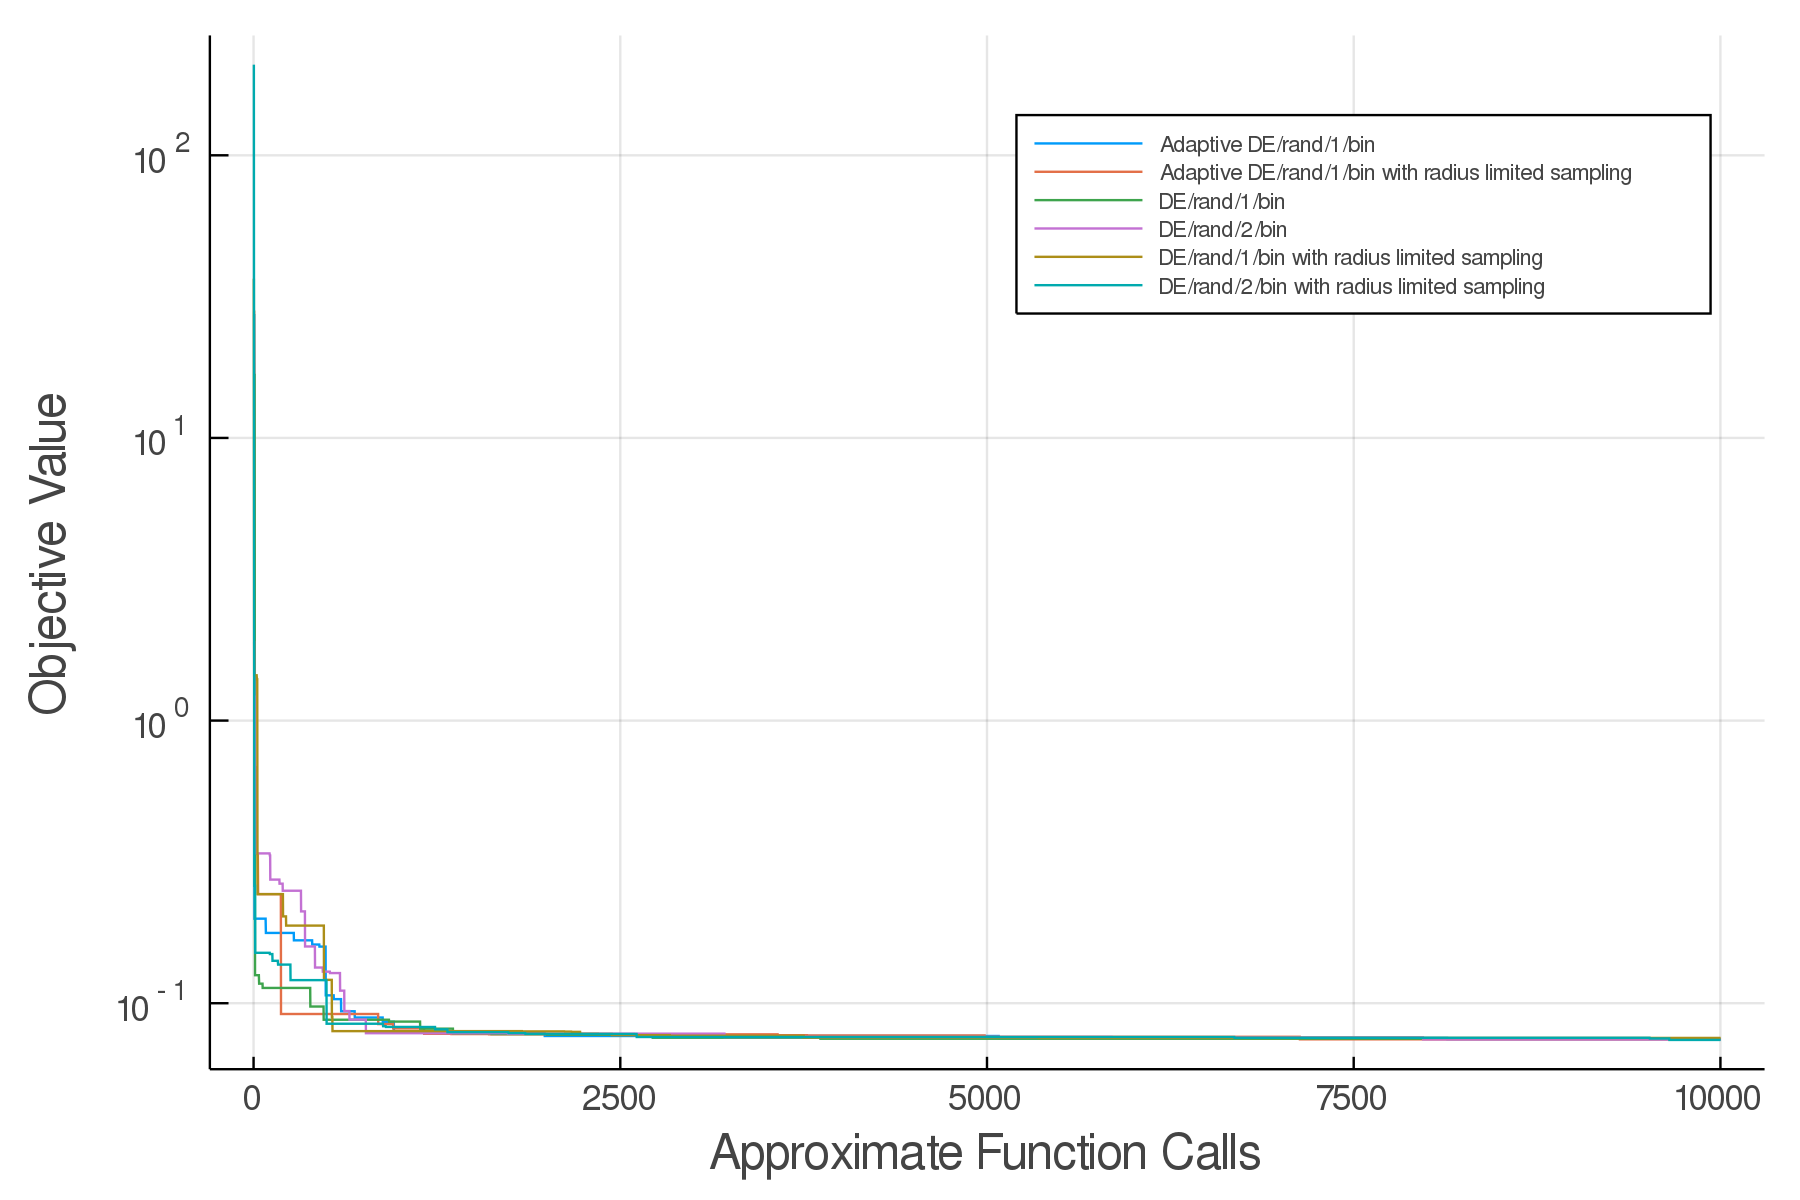

In [36]:
plot(first.(adaptive_de_rand_1_bin_trace), last.(adaptive_de_rand_1_bin_trace), label = "Adaptive DE/rand/1/bin")
plot!(first.(adaptive_de_rand_1_bin_radiuslimited_trace), last.(adaptive_de_rand_1_bin_radiuslimited_trace), label = "Adaptive DE/rand/1/bin with radius limited sampling")
plot!(first.(de_rand_1_bin_trace), last.(de_rand_1_bin_trace), label = "DE/rand/1/bin")
plot!(first.(de_rand_2_bin_trace), last.(de_rand_2_bin_trace), label = "DE/rand/2/bin")
plot!(first.(de_rand_1_bin_radiuslimited_trace), last.(de_rand_1_bin_radiuslimited_trace), label = "DE/rand/1/bin with radius limited sampling")
plot!(first.(de_rand_2_bin_radiuslimited_trace), last.(de_rand_2_bin_radiuslimited_trace), label = "DE/rand/2/bin with radius limited sampling")
plot!(yaxis = :log, dpi = 300, format = :png, ylabel = "Objective Value", 
    xlabel = "Approximate Function Calls", legendfontsize=5)

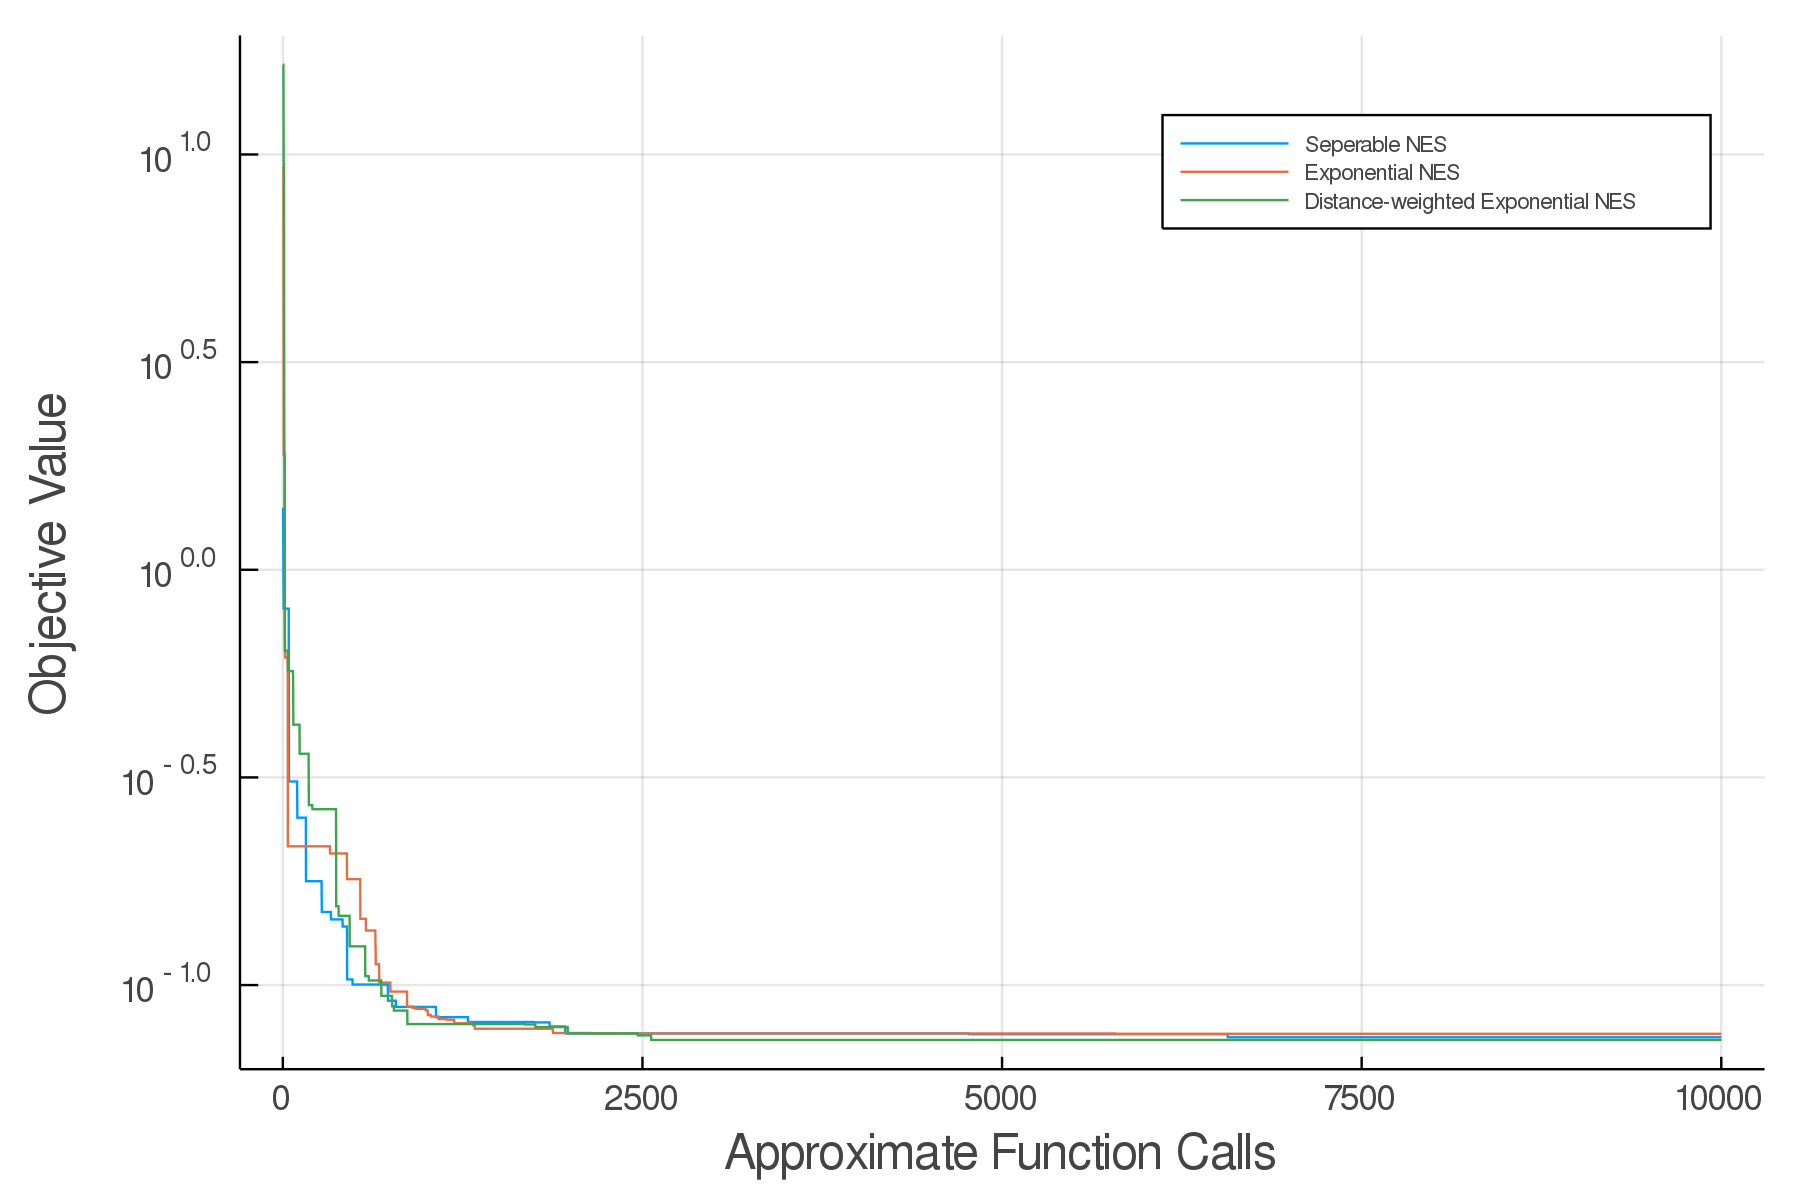

In [37]:
plot(first.(separable_nes_trace), last.(separable_nes_trace), label = "Seperable NES")
plot!(first.(xnes_trace), last.(xnes_trace), label = "Exponential NES")
plot!(first.(dxnes_trace), last.(dxnes_trace), label = "Distance-weighted Exponential NES")
plot!(yaxis = :log, dpi = 300, format = :png, ylabel = "Objective Value", 
    xlabel = "Approximate Function Calls", legendfontsize=5)

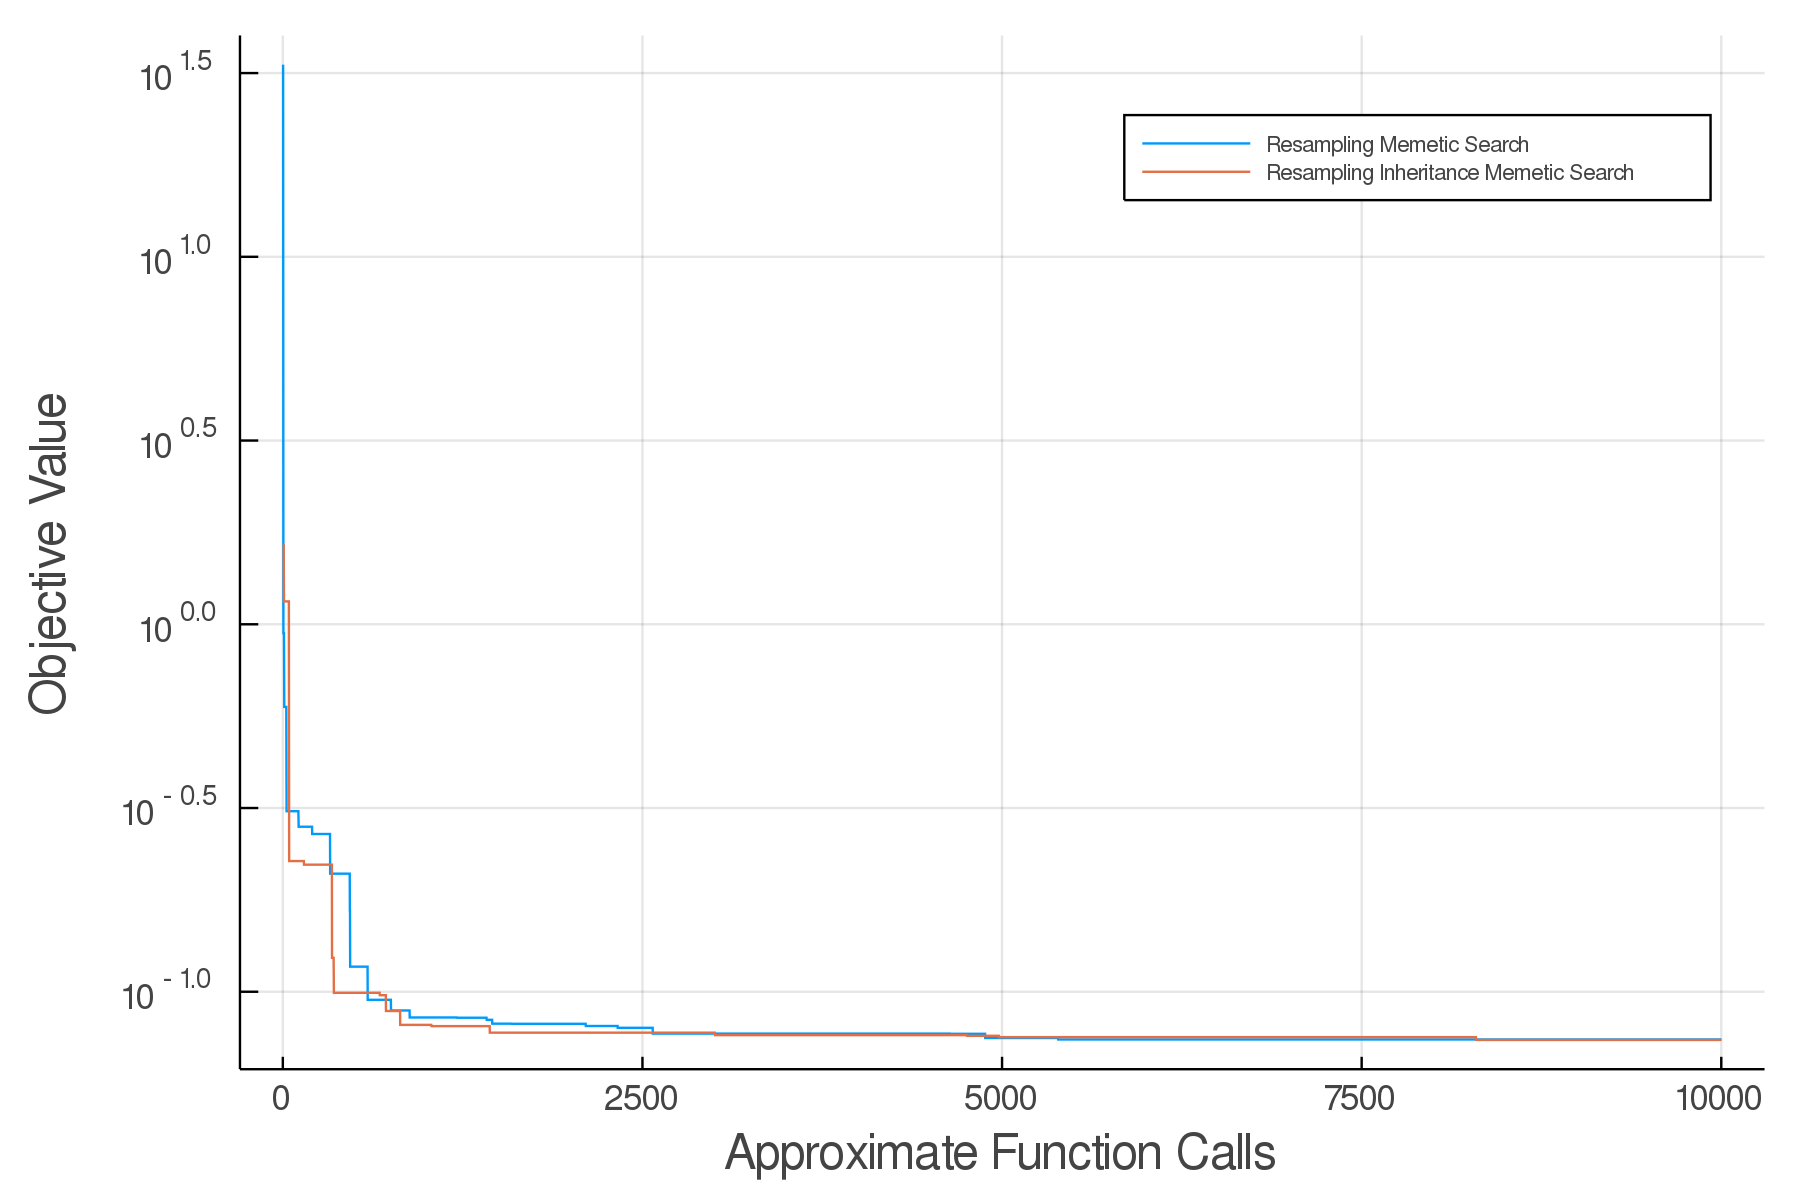

In [39]:
plot(first.(resampling_memetic_search_trace), last.(resampling_memetic_search_trace), label = "Resampling Memetic Search")
plot!(first.(resampling_inheritance_memetic_search_trace), last.(resampling_inheritance_memetic_search_trace), label = "Resampling Inheritance Memetic Search")
plot!(yaxis = :log, dpi = 300, format = :png, ylabel = "Objective Value", 
    xlabel = "Approximate Function Calls", legendfontsize=5)

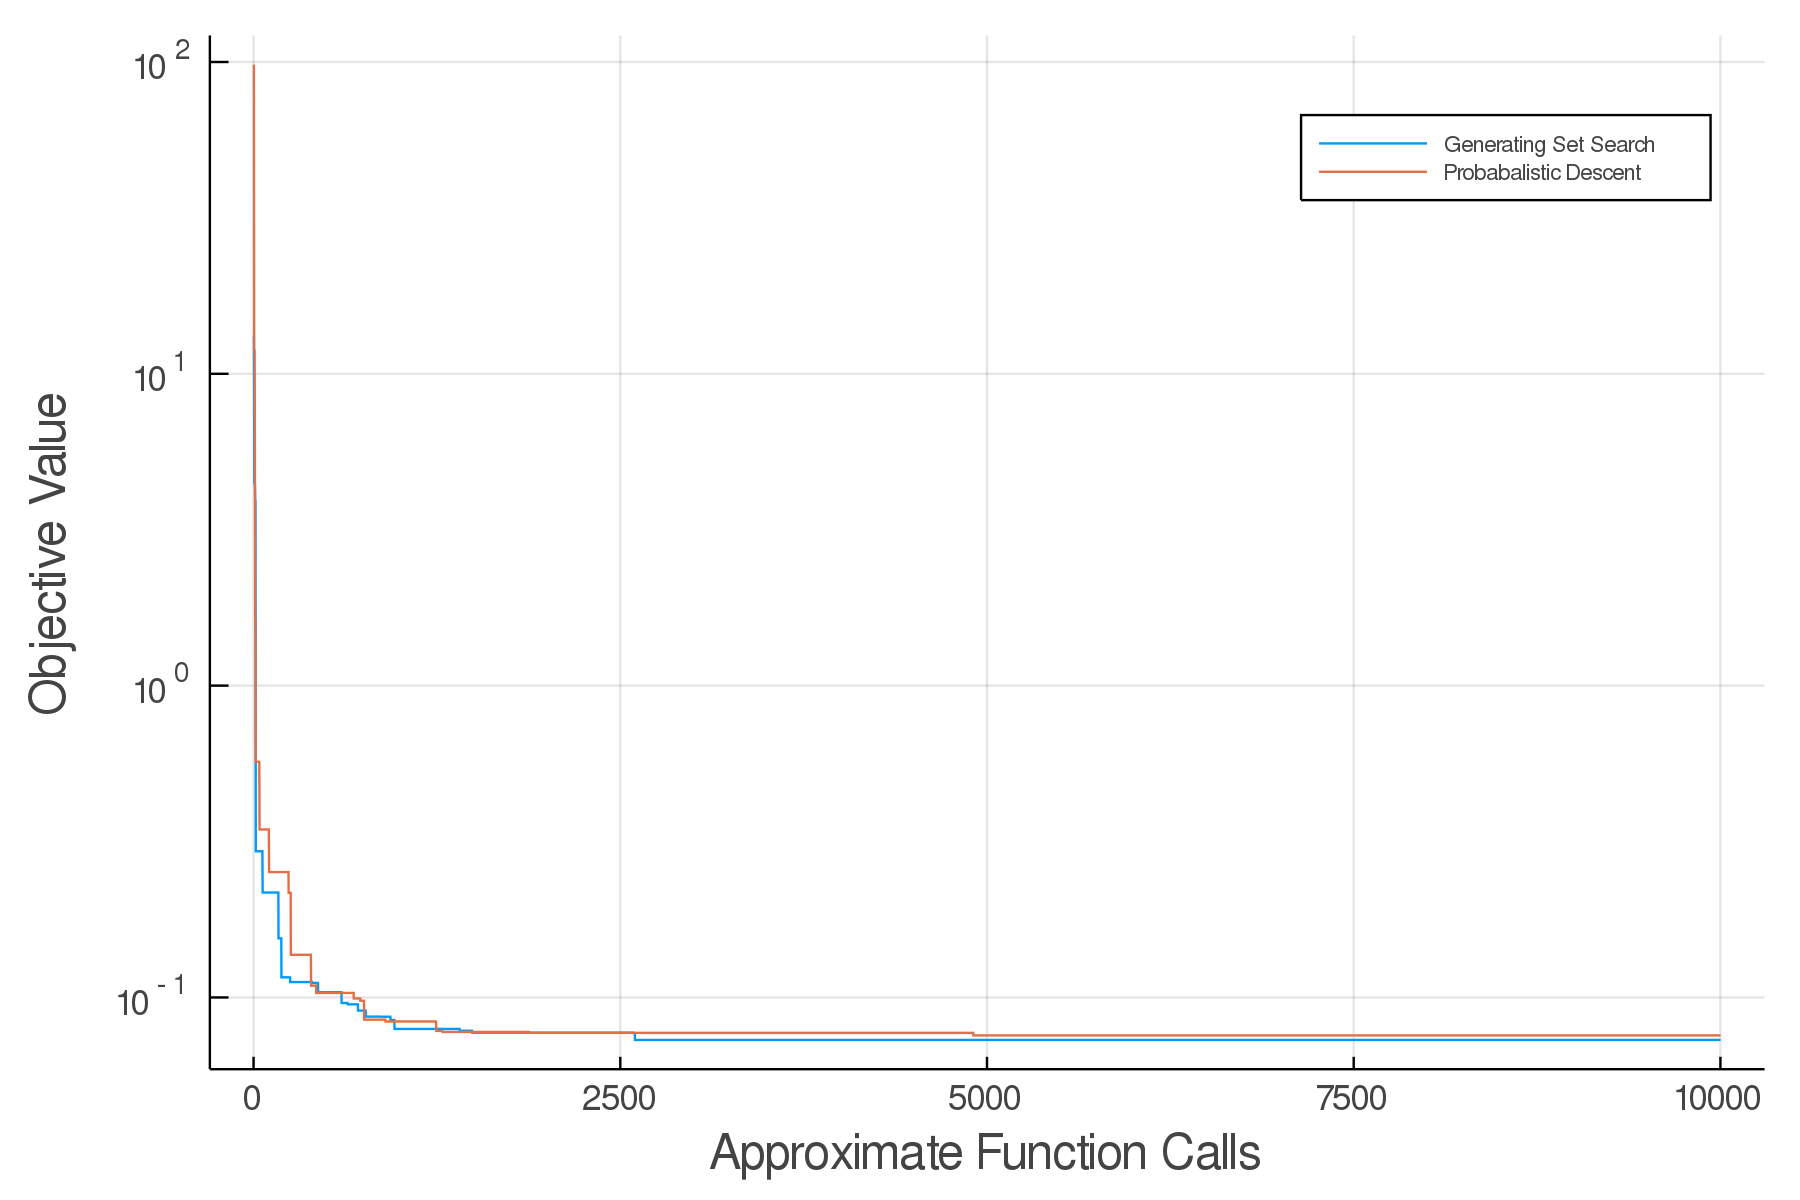

In [40]:
plot(first.(generating_set_search_trace), last.(generating_set_search_trace), label = "Generating Set Search")
plot!(first.(probabilistic_descent_trace), last.(probabilistic_descent_trace), label = "Probabalistic Descent")
plot!(yaxis = :log, dpi = 300, format = :png, ylabel = "Objective Value", 
    xlabel = "Approximate Function Calls", legendfontsize=5)

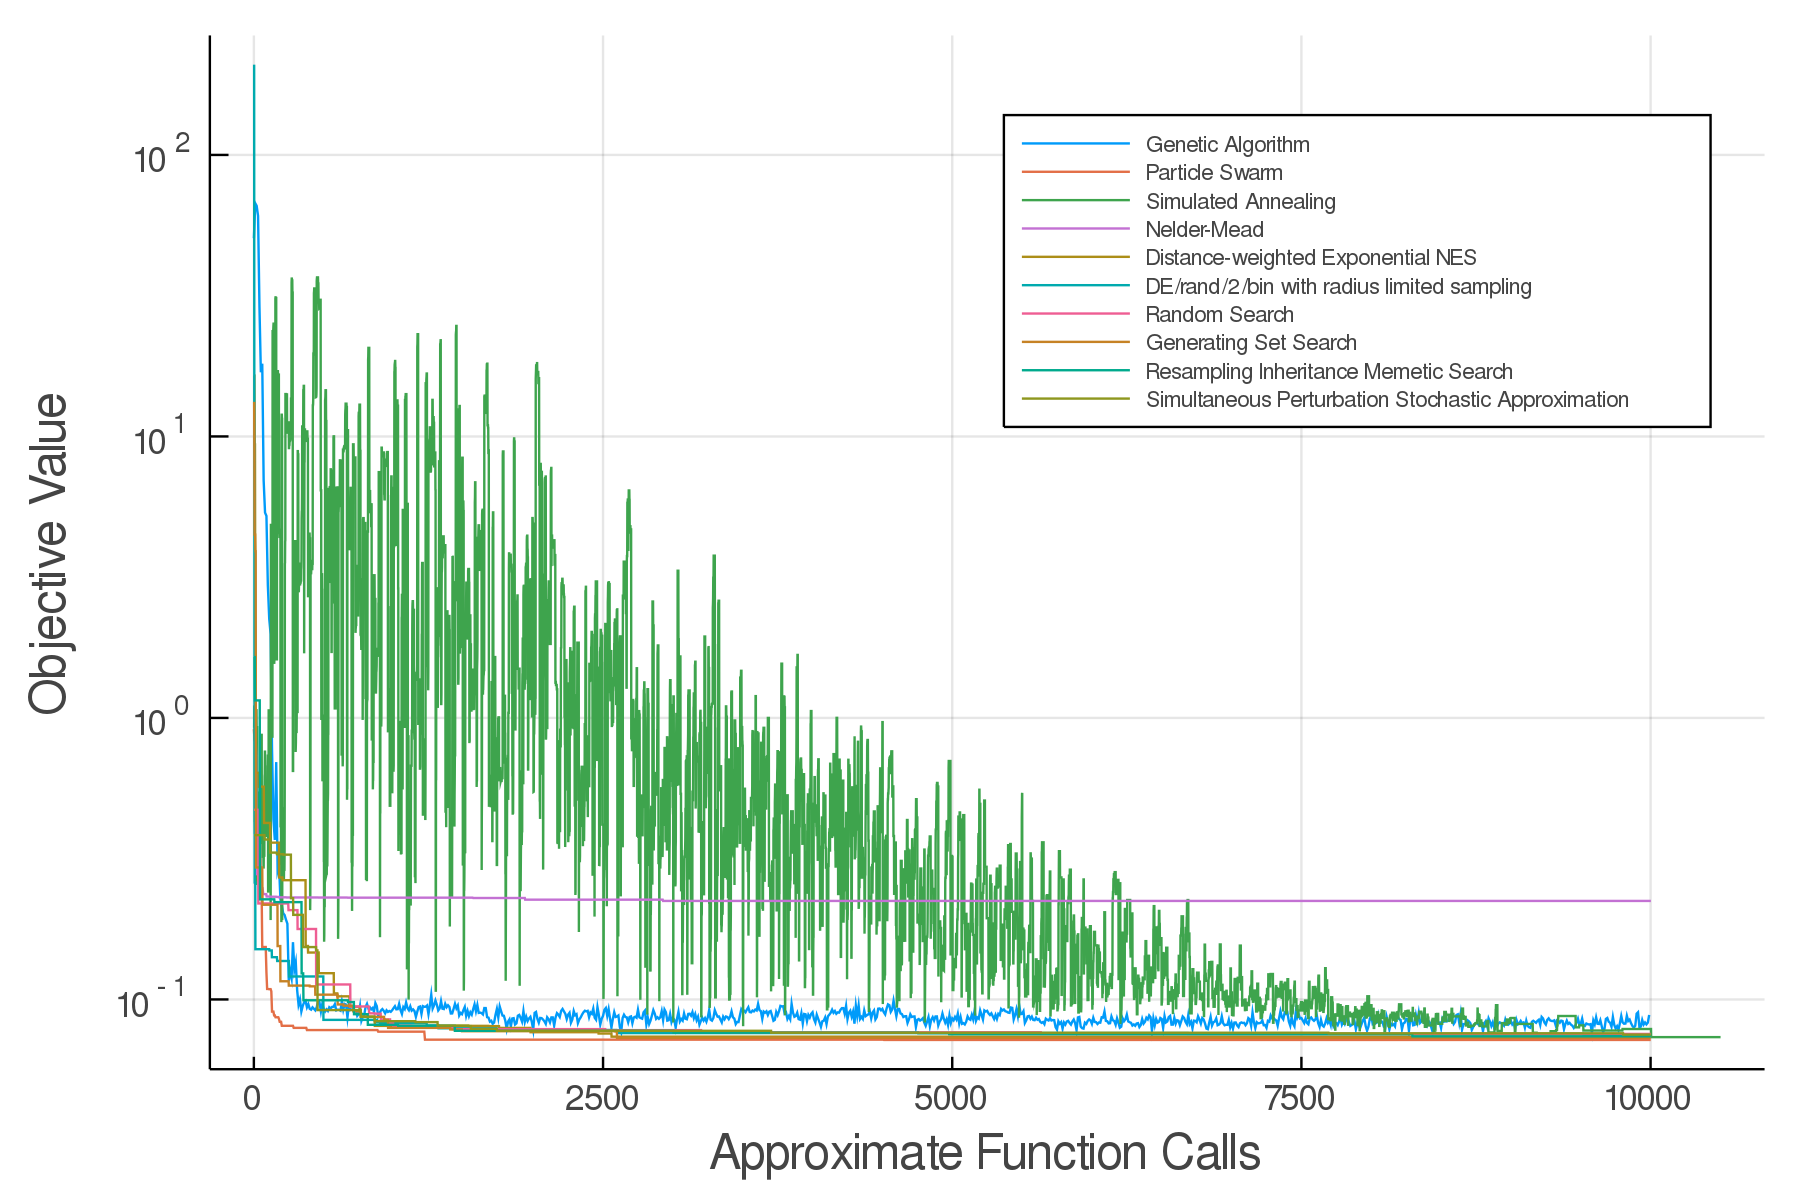

In [41]:
N = 10_000
plot(0:(N ÷ length(ga_mins)):(N - 1), ga_mins, label = "Genetic Algorithm")
plot!(collect(0:particle_swarm_result.iterations) .* (particle_swarm_result.f_calls / 
    particle_swarm_result.iterations), map(x -> x.value, particle_swarm_result.trace), 
    label = "Particle Swarm")
plot!(collect(1:simulated_annealing_result.iterations) .* (simulated_annealing_result.f_calls / 
    simulated_annealing_result.iterations), map(x -> x.value, simulated_annealing_result.trace), 
    label = "Simulated Annealing")
plot!(collect(0:nelder_mead_result.iterations) .* (nelder_mead_result.f_calls / 
    nelder_mead_result.iterations), map(x -> x.value, nelder_mead_result.trace), label = "Nelder-Mead")
plot!(first.(dxnes_trace), last.(dxnes_trace), label = "Distance-weighted Exponential NES")
plot!(first.(de_rand_2_bin_radiuslimited_trace), last.(de_rand_2_bin_radiuslimited_trace), 
    label = "DE/rand/2/bin with radius limited sampling")
plot!(first.(random_search_trace), last.(random_search_trace), label = "Random Search")
plot!(first.(generating_set_search_trace), last.(generating_set_search_trace), label = "Generating Set Search")
plot!(first.(resampling_inheritance_memetic_search_trace), last.(resampling_inheritance_memetic_search_trace),
    label = "Resampling Inheritance Memetic Search")
plot!(first.(simultaneous_perturbation_stochastic_approximation_trace), last.(
    simultaneous_perturbation_stochastic_approximation_trace), label = 
    "Simultaneous Perturbation Stochastic Approximation")
plot!(yaxis = :log, dpi = 300, format = :png, ylabel = "Objective Value", 
    xlabel = "Approximate Function Calls", legendfontsize=5)